In [11]:
import pandas as pd
import numpy as np
from dateutil import parser
import re
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [12]:
books = pd.read_csv('data/books.csv')
checkouts = pd.read_csv('data/checkouts.csv')
customers = pd.read_csv('data/customers.csv')
libraries = pd.read_csv('data/libraries.csv')

In [13]:
late_return_time = 28

## Cleaning Dates
---

* Date formats aren't unified so we can't use the 'parse_dates' argument of 'read_csv()'
* Need to clean them before parsing

In [14]:
def date_cleaner(x):
    return re.sub(r'[%|]', ' ', x)

parse_date = lambda x: np.nan if x is np.nan else parser.parse(date_cleaner(x))

In [15]:
checkouts['date_checkout'] = checkouts['date_checkout'].apply(parse_date)
checkouts['date_returned'] = checkouts['date_returned'].apply(parse_date)
books['publishedDate'] = books['publishedDate'].apply(parse_date)
customers['birth_date'] = customers['birth_date'].apply(parse_date)

In [16]:
print('date_checkout max: ' + str(max(checkouts['date_checkout'])))
print('date_checkout min: ' + str(min(checkouts['date_checkout'])))

print('date_returned max: ' + str(max(checkouts['date_returned'])))
print('date_returned min: ' + str(min(checkouts['date_returned'])))

print('publishedDate max: ' + str(max(books['publishedDate'])))
print('publishedDate min: ' + str(min(books['publishedDate'])))

print('birth_date max: ' + str(max(customers['birth_date'])))
print('birth_date min: ' + str(min(customers['birth_date'])))

date_checkout max: 2120-09-06 00:00:00
date_checkout min: 1800-08-09 00:00:00
date_returned max: 2120-09-14 00:00:00
date_returned min: 1800-04-28 00:00:00
publishedDate max: 2021-02-17 00:00:00
publishedDate min: 1830-01-04 00:00:00
birth_date max: 2120-08-25 00:00:00
birth_date min: 1800-02-19 00:00:00


* There are dates in the future and in the distant past, these should be removed before analysis

array([<Axes: title={'center': 'date_returned'}>], dtype=object)

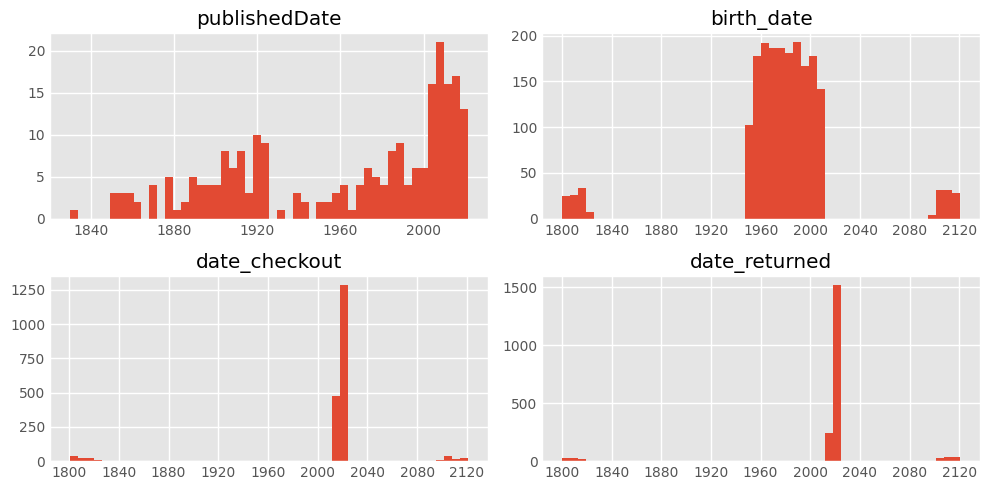

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), tight_layout=True)
books.hist(column='publishedDate', bins=50, ax=ax[0][0])
customers.hist(column='birth_date', bins=50, ax=ax[0][1])
checkouts.hist(column='date_checkout', bins=50, ax=ax[1][0])
checkouts.hist(column='date_returned', bins=50, ax=ax[1][1])

* Looking at histograms, we can conclude that these are outliers and can be removed using IQR
* If this was not the case, we could find library opening years and use this as minimum possible date, and remove minors or persons above a certain age from customers column
* For now, these values will be replaced by nan

In [18]:
def replace_outliers(df, col):
    IQR = (q1:=df[col].quantile(0.75)) - (q2:=df[col].quantile(0.25))

    df.loc[(df[col] < q1-1.5*IQR) | (df[col] > q2+1.5*IQR), col] = np.nan

In [19]:
replace_outliers(customers, 'birth_date')
replace_outliers(checkouts, 'date_checkout')
replace_outliers(checkouts, 'date_returned')

array([<Axes: title={'center': 'date_returned'}>], dtype=object)

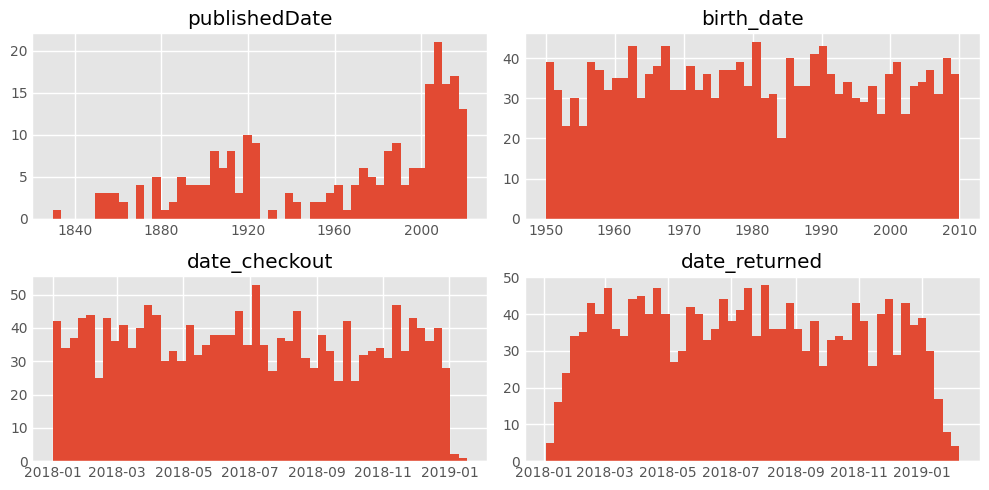

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), tight_layout=True)
books.hist(column='publishedDate', bins=50, ax=ax[0][0])
customers.hist(column='birth_date', bins=50, ax=ax[0][1])
checkouts.hist(column='date_checkout', bins=50, ax=ax[1][0])
checkouts.hist(column='date_returned', bins=50, ax=ax[1][1])

### Removing unusable rows

* Rows from checkouts table with missing or incorrect dates cannot be used for prediction, so these will be removed
* Due to legal constraints with processing minors data, customers under 16 years of age (at the time of checkout) will be removed from the dataset. 16 is chosen in accordance to GDPR art. 8.

In [22]:
checkouts = checkouts[(~checkouts['date_checkout'].isna())&(~checkouts['date_returned'].isna())]

In [25]:
checkouts.head()

,id,patron_id,library_id,date_checkout,date_returned
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25
6,CW-7tHAaVR0C,dd9f34e9d65126a2b02003d8ac60aaa4,22c-222@5xc-jwj-pvz,2018-01-10,2018-02-04
8,t1e3BWziAc8C,3b85b2c7b424618f533329018e9a11d5,222-222@5xc-jv5-nt9,2018-06-23,2018-07-14


In [28]:
customers_tmp = customers[['id', 'birth_date']].merge(checkouts[['patron_id', 'date_checkout']], left_on='id', right_on='patron_id')

In [36]:
ids_to_remove = customers_tmp[(customers_tmp['date_checkout']-customers_tmp['birth_date'])<pd.to_timedelta(16*365, unit='day')].patron_id